# Previsão do desempenho (nota geral) do candidato
- Neste notebook, será realizada uma tarefa de regressão, que consiste na previsão da nota geral do candidato (target) com base nas variáveis que vimos na análise exploratória de dados. Será aplicado o aprendizado supervisionado, com um conjunto de dados rotulado e um target numérico.
- O objetivo consiste em construir um modelo de machine learning capaz de prever acuradamente a nota geral do candidato. Além disso, avaliar quais variáveis independentes impactam mais e menos a nota.
- Para isso, técnicas de limpeza e pré-processamento de dados, treinamento e validação de modelos de machine learning serão aplicadas.
- Todo esse processo será baseado no framework CRISP-DM, podendo envolver ciclos de pré-processamento e validação de modelos repetidamente.
- Pipeline de modelagem:
    - Divisão dos dados em treino, teste e validação.
    - Limpeza e pré-processamento dos dados.
    - Comparação e seleção de modelo potencial com validação cruzada k-fold.
    - Seleção de features.
    - Tunagem de hiperparâmetros.
    - Avaliação final no conjunto de testes (simulando o ambiente de produção).
    - Deploy.
- Finalmente, um modelo de previsão de notas pode fornecer informações valiosas para informar decisões educacionais e políticas governamentais, visando melhorar a qualidade e a eficácia do sistema educacional. Alguns exemplos de aplicações:
    - Avaliação do Desempenho Educacional.
    - Identificação de Necessidades Individuais.
    - Identificação de Talentos e Potenciais.
    - Alocação Eficiente de Recursos.
    - Planejamento Estratégico de Longo Prazo.
    - Avaliação de Intervenções Educacionais.

#### 1. Importando as bibliotecas

In [10]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling.
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from feature_engine.selection import ProbeFeatureSelection
import optuna
import shap
shap.initjs()
from src.modelling_utils import *

# Definições de cores -> todas estão numa escala de mais escura para mais clara.
CINZA1, CINZA2, CINZA3 = '#231F20', '#414040', '#555655'
CINZA4, CINZA5, CINZA6 = '#646369', '#76787B', '#828282'
CINZA7, CINZA8, CINZA9 = '#929497', '#A6A6A5', '#BFBEBE'
AZUL1, AZUL2, AZUL3, AZUL4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
VERMELHO1, VERMELHO2, VERMELHO3, VERMELHO4, VERMELHO5 = '#DB0527', '#E23652', '#ED8293', '#F4B4BE', '#FBE6E9'
VERDE1, VERDE2 = '#0C8040', '#9ABB59'
LARANJA1 = '#F79747'
AMARELO1, AMARELO2, AMARELO3, AMARELO4, AMARELO5 = '#FFC700', '#FFCC19', '#FFEB51', '#FFE37F', '#FFEEB2'
BRANCO = '#FFFFFF'

# Visualize all the columns.
pd.set_option('display.max_columns', None)

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

#### 2. Coletando os dados
- Considerando que estamos tentando prever o desempenho do candidato na prova, serão incluídos na modelagem apenas dados de estudantes que compareceram em ambos os dias de prova, como visto na Análise de Desempenho no notebook '2_eda.ipynb'. Dessa forma, evitamos distorções e assimetrias, afinal, alunos que não comparecem ficam com nota nula.
- Antes de tudo, iremos criar o target para a modelagem de desempenho, que consiste na nota geral (média das 5 notas). Isso permitirá a divisão dos dados em treino, teste e validação e a aplicação correta do pré-processamento dos dados.
- Então, serão removidas observações de estudantes que obtiveram nota 0, considerando a sua baixíssima frequência (22 observações) e considerando que estamos supondo que, uma vez presente, o aluno realizará a prova conforme é previsto. Ademais, isso permitirá que calculemos métricas como o MAPE.

In [2]:
# Read the memory optimized data.
path = '/Users/pedrohenriquealmeidaoliveira/Documents/data_science/Enem-Analysis/input/data/clean_df.parquet'
df = pd.read_parquet(path)

# Select only students who were present in both the days of the exam.
df = df.loc[(df['presenca_lc'] == 'Presente') & \
            (df['presenca_ch'] == 'Presente') & \
            (df['presenca_cn'] == 'Presente') & \
            (df['presenca_mt'] == 'Presente')].reset_index(drop=True)

# Create the target variable.
df['nota_geral'] = (df['nota_lc'] + df['nota_ch'] + \
                    df['nota_cn'] + df['nota_mt'] + \
                    df['nota_redacao']) / 5

# Remove null grade candidates.
df = df.loc[~(df['nota_geral'] == 0)]

#### 2.1 Rápida visualização e informações gerais

In [7]:
df.head()

,faixa_etaria,sexo,estado_civil,status_conclusao_ensino_medio,escola,treineiro,municipio_prova,uf_prova,presenca_cn,presenca_ch,presenca_lc,presenca_mt,nota_cn,nota_ch,nota_lc,nota_mt,lingua,nota_comp1,nota_comp2,nota_comp3,nota_comp4,nota_comp5,nota_redacao,escolaridade_pai,escolaridade_mae,numero_pessoas_em_casa,renda_familiar_mensal,possui_celular_em_casa,possui_computador_em_casa,acesso_internet_em_casa,nota_geral
0,Jovem adulto (18-24),F,Solteiro(a),Concluído,Não respondeu,Não,Presidente Tancredo Neves,BA,Presente,Presente,Presente,Presente,421.100006,546.000000,498.799988,565.299988,Espanhol,140.0,200.0,120.0,140.0,160.0,760.0,Ensino médio completo,Ensino superior completo,2,"Até R$ 1.212,00",Dois ou mais,Não,Sim,558.239990
1,Jovem adulto (18-24),M,Solteiro(a),Concluído,Não respondeu,Não,Cariacica,ES,Presente,Presente,Presente,Presente,490.700012,388.600006,357.799988,416.000000,Espanhol,120.0,40.0,40.0,100.0,20.0,320.0,Ensino fundamental incompleto,Nunca estudou,3,Nenhuma Renda,Dois ou mais,Um,Sim,394.620026
2,Jovem adulto (18-24),F,Solteiro(a),Concluído,Não respondeu,Não,São Gonçalo,RJ,Presente,Presente,Presente,Presente,398.100006,427.299988,400.200012,404.899994,Espanhol,100.0,120.0,80.0,100.0,40.0,440.0,Ensino médio completo,Ensino médio completo,5,"Até R$ 1.212,00",Dois ou mais,Não,Sim,414.100006
3,Jovem adulto (18-24),F,Solteiro(a),Concluído,Não respondeu,Não,Arcoverde,PE,Presente,Presente,Presente,Presente,467.500000,461.000000,466.700012,435.299988,Espanhol,80.0,80.0,80.0,80.0,40.0,360.0,Ensino médio completo,Ensino médio completo,2,"Até R$ 1.212,00",Um,Não,Sim,438.100006
4,Adolescente (< 18),F,Solteiro(a),Último ano,Privada,Não,Nossa Senhora da Glória,SE,Presente,Presente,Presente,Presente,458.700012,539.799988,488.200012,456.799988,Espanhol,160.0,200.0,180.0,200.0,200.0,940.0,Ensino médio completo,Ensino médio completo,4,"Até R$ 1.212,00",Dois ou mais,Não,Sim,576.700012


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2344801 entries, 0 to 2344822
Data columns (total 31 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   faixa_etaria                   category
 1   sexo                           category
 2   estado_civil                   category
 3   status_conclusao_ensino_medio  category
 4   escola                         category
 5   treineiro                      category
 6   municipio_prova                object  
 7   uf_prova                       category
 8   presenca_cn                    category
 9   presenca_ch                    category
 10  presenca_lc                    category
 11  presenca_mt                    category
 12  nota_cn                        float32 
 13  nota_ch                        float32 
 14  nota_lc                        float32 
 15  nota_mt                        float32 
 16  lingua                         category
 17  nota_comp1                     f

In [46]:
print(f'O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.')

O dataset possui 2344801 linhas e 31 colunas.


#### 2.2 Valores nulos e duplicados
- Valores nulos e duplicados, tipos de dados, entre outros processos já foram tratados no notebook '1_data_cleaning.ipynb'. Além disso, muitas variáveis irrelevantes já foram removidas. Iremos realizar daqui para frente, um refinamento com propósitos de modelagem, afinal, a limpeza inicial foi feita direcionada à análise exploratória de dados.

In [10]:
df.isna().sum()

faixa_etaria                     0
sexo                             0
estado_civil                     0
status_conclusao_ensino_medio    0
escola                           0
treineiro                        0
municipio_prova                  0
uf_prova                         0
presenca_cn                      0
presenca_ch                      0
presenca_lc                      0
presenca_mt                      0
nota_cn                          0
nota_ch                          0
nota_lc                          0
nota_mt                          0
lingua                           0
nota_comp1                       0
nota_comp2                       0
nota_comp3                       0
nota_comp4                       0
nota_comp5                       0
nota_redacao                     0
escolaridade_pai                 0
escolaridade_mae                 0
numero_pessoas_em_casa           0
renda_familiar_mensal            0
possui_celular_em_casa           0
possui_computador_em

#### 2.3 Variáveis numéricas e categóricas
- Irei verificar as variáveis numéricas e categóricas.
- Isso influenciará a escolha de encoders e scalers futuramente na etapa de pré-processamento de dados. Cardinalidade é um fator importante a ser considerado.

In [11]:
categorical_features = df.select_dtypes(['category', 'object']).columns.to_list()
numerical_features = df.select_dtypes('number').columns.to_list()
print(f'Há {len(categorical_features)} variáveis categóricas. São elas: {categorical_features}')
print(f'Há {len(numerical_features)} variáveis numéricas. São elas: {numerical_features}')

Há 19 variáveis categóricas. São elas: ['faixa_etaria', 'sexo', 'estado_civil', 'status_conclusao_ensino_medio', 'escola', 'treineiro', 'municipio_prova', 'uf_prova', 'presenca_cn', 'presenca_ch', 'presenca_lc', 'presenca_mt', 'lingua', 'escolaridade_pai', 'escolaridade_mae', 'renda_familiar_mensal', 'possui_celular_em_casa', 'possui_computador_em_casa', 'acesso_internet_em_casa']
Há 12 variáveis numéricas. São elas: ['nota_cn', 'nota_ch', 'nota_lc', 'nota_mt', 'nota_comp1', 'nota_comp2', 'nota_comp3', 'nota_comp4', 'nota_comp5', 'nota_redacao', 'numero_pessoas_em_casa', 'nota_geral']


In [12]:
print('Cardinalidade das variáveis categóricas: ')
for feature in categorical_features:
    print(f'{feature} ({df[feature].nunique()})', end=', ')

Cardinalidade das variáveis categóricas: 
faixa_etaria (7), sexo (2), estado_civil (5), status_conclusao_ensino_medio (4), escola (3), treineiro (2), municipio_prova (1712), uf_prova (27), presenca_cn (1), presenca_ch (1), presenca_lc (1), presenca_mt (1), lingua (2), escolaridade_pai (7), escolaridade_mae (7), renda_familiar_mensal (10), possui_celular_em_casa (3), possui_computador_em_casa (3), acesso_internet_em_casa (2), 

In [13]:
print('Domínios das variáveis categóricas: ')
print()
for feature in categorical_features:
    print(f'{feature} ({df[feature].value_counts(normalize=True) * 100})')
    print()

Domínios das variáveis categóricas: 

faixa_etaria (faixa_etaria
Jovem adulto (18-24)            53.912897
Adolescente (< 18)              35.137066
Adulto jovem (25-35)             7.054605
Adulto de meia idade (36-45)     2.485774
Meia idade (46-55)               1.051167
Pré aposentadoria (56-65)        0.308723
Idoso (> 66)                     0.049769
Name: proportion, dtype: float64)

sexo (sexo
F    61.269785
M    38.730215
Name: proportion, dtype: float64)

estado_civil (estado_civil
Solteiro(a)                  92.323173
Casado(a)/União Estável       3.337182
Não informado                 3.115928
Divorciado(a)/Separado(a)     1.145971
Viúvo(a)                      0.077746
Name: proportion, dtype: float64)

status_conclusao_ensino_medio (status_conclusao_ensino_medio
Concluído        41.074273
Último ano       40.844490
Cursando         17.786844
Não concluído     0.294393
Name: proportion, dtype: float64)

escola (escola
Não respondeu    59.155510
Pública          32.448206


Insights, feature engineering e pré-processamentos:
- Possuem característica ordinal as variáveis: faixa_etaria, status_conclusao_ensino_medio, escolaridade_pai, escolaridade_mae, renda_familiar_mensal, possui_celular_em_casa e possui_computador_em_casa.
- A variável municipio_prova possui altíssima cardinalidade (1712 domínios distintos), não sendo relevante para a análise. Portanto, será removida.
- A variável treineiro não apresentou nenhuma distinção de distribuição da nota geral entre suas categorias, portanto, será removida.
- Variáveis representando a presença ou ausência do candidato serão removidas, afinal, estamos lidando apenas com candidatos presentes e estas não só serão irrelevantes para a modelagem, bem como possuem variância constante.
- Variáveis contendo a nota do candidato nas diferentes áreas do conhecimento, redação ou competências da redação serão removidas a fim de evitar data leakage. Não sabemos qual a nota do candidato em nada no ambiente de produção, isso é justamente o que queremos prever. Incluí-las criaria um cenário irreal, superestimando a performance do modelo.
- Apesar de a variável estado civil estar altamente desbalanceada, com mais de 92% das observações pertencendo à categoria "Solteiro(a)" e mais de 3% estando como "Não informado", foi notado durante a EDA que há distinções na nota geral entre as diferentes categorias. Portanto, ela será mantida, pois pode ajudar o modelo. Dado que a categoria "Não informado" apresenta também uma distribuição distinta, apresentando a segunda maior nota geral média, esta será mantida como categoria de estado civil. O mesmo vale para possui_celular em casa e acesso_internet_em_casa.
- A variável uf_prova também possui alta cardinalidade e será agrupada em uma nova variável chamada "região". Essa nova variável manterá a informação e permitirá melhor aproveitamento pelo modelo, reduzindo a cardinalidade.
- Nas variáveis representando a escolaridade do pai e da mãe, há uma categoria "Não sei". Esse valor se deve provavelmente por falta de conhecimento sobre a escolaridade do responsável por parte do candidato. Uma vez que essas observações constituem uma porção significativa dos dados (em escolaridade_pai, mais de 8%, por exemplo) e que as notas gerais dentro dessa categoria tendem a ser baixas, estando próximas às de candidatos cuijos pais nunca estudaram, irei tratá-la como sendo mais uma categoria da variável. Imputar valores poderia introduzir um viés, dada a alta frequência desses registros e a informação contida neles (notas dentre as mais baixas).
- Dadas as baixíssimas proporções, a diferença mínima nas distribuições e notas gerais médias observadas na eda e a adjacência (variáveis ordenadas), irei fundir as categorias Pré aposentadoria (56-65) e Idoso (> 66), Adulto de meia idade (36-45) e Meia idade (46-55) na variável faixa_etaria. Isso reduz a cardinalidade e previne o overfit. O mesmo vale para a variável renda_familiar_mensal, que terá categorias fundidas com os mesmos objetivos.
- Apesar de a variável escola possuir 60% das observações registradas como "Não respondeu", irei incluí-la na modelagem. Isso porque, durante a eda foi possível perceber que as categorias pública e privada possuíam clara distinção na distribuição da nota geral e na nota geral média. Além disso, dado que a categoria "Não respondeu" carrega informação, estando "no meio" de ambas distribuições, irei mantê-la como outra categoria da variável escola. 
- Irei criar a variável acesso_tecnologico que consiste na soma das variáveis acesso_internet_em_casa, possui_celular_em_casa e possui_computador_em_casa, já em formato binário e ordinal. Com isso, eu pretendo informar ao modelo as condições tecnológicas do estudante, uma vez que esse é um fator determinante no seu desempenho.
- Irei criar a variável renda_por_pessoa dividindo um valor intermediário nas faixas de renda, já que as faixas possuem intervalos com pouca distância, pelo número de pessoas em casa. Essa variável pode ajudar o modelo, quantificando de fato impactos da renda e do número de residentes na nota geral do candidato. Ademais, outras combinações de atributos serão criadas, como renda_por_acesso_tecnologico e acesso_tecnologico_por_pessoa.
- Irei categorizar a variável numero_pessoas_casa, uma vez que ela possui valores indo de 1 a 20 e baixíssimas proporções em valores mais altos. Ademais, durante a EDA foi visto que ela não possui relação linear com o target. Portanto, para modelos lineares (em que a linearidade das variáveis independentes com a variável resposta é uma das premissas), essa categorização é benéfica pois, ao criar-se dummies, cada categoria terá um peso diferente.
- Tudo isso será realizado através de classes, que aplicam o pré-processamento supracitado, e podem ser integradas a um pipeline, facilitando o controle e o fluxo em produção. As classes encontram-se no arquivo "modelling_utils.py" e serão aplicadas na etapa de pré-processamento abaixo.

#### 2.4. Split dos dados em sets de treino, teste e validação
- Os dados de teste são dados que o modelo nunca viu. Por isso, irei realizar o split antes de qualquer coisa. O teste será isolado e utilizado apenas no final para avaliar uma vez o melhor modelo escolhido. Isso garantirá uma avaliação de performance confiável, simulando um ambiente real de produção. Ademais, data leakage também é evitado, aplicando apenas 'transform' neste conjunto.
- Os dados de validação serão utilizados na tunagem de hiperparâmetros para avaliar o modelo treinado em cada configuração. Isso nos ajuda a prevenir o overfitting, evitando decisões baseadas em ajuste excessivo ao conjunto de treinamento.

In [3]:
# Obtain predictor and target sets.
X = df.drop(columns=['nota_geral'])
y = df['nota_geral'].copy()

# Set 80% training, 10% test and 10% validation.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train predictor set shape: {X_train.shape}. Train target set shape: {y_train.shape}')
print(f'Test predictor set shape: {X_test.shape}. Test target set shape: {y_test.shape}')
print(f'Validation predictor set shape: {X_val.shape}. Validation target set shape: {y_val.shape}')

Train predictor set shape: (1875840, 30). Train target set shape: (1875840,)
Test predictor set shape: (234480, 30). Test target set shape: (234480,)
Validation predictor set shape: (234481, 30). Validation target set shape: (234481,)


#### 4. Pré-processamento dos dados
- Considerando as nuances de pré-processamento distintas entre modelos lineares e modelos baseados em árvore, construirei dois pipelines de pré-processamento.
1. Pré-processamento para modelos lineares:
    - Variáveis numéricas: Algoritmos como a Regressão Linear são sensíveis ao escalonamento de características, pois utilizam cálculos baseados em distância ou otimizações como gradiente descendente. Portanto, aplicarei o StandardScaler às variáveis numéricas.
    - Variáveis categóricas: Algoritmos de machine learning efetuam cálculos matemáticos. Portanto, é necessário converter as variáveis categóricas para numéricas aplicando técnicas de encoding. Aplicarei o OneHotEncoder às variáveis categóricas, pois modelos lineares tendem a se beneficiar desta técnica de encoding. Por exemplo, variáveis que não apresentavam relação linear monotônica com o target terão suas categorias tratadas de forma distinta, tendo um peso atribuído a cada, fazendo com que a premissa de linearidade não seja quebrada.
    - Para modelos lineares, especialmente a regressão linear, temos algumas premissas que devem ser atendidas, principalmente em casos onde se quer inferir relações a partir dos coeficientes - linearidade das variáveis independentes com o target, ausência de multicolinearidade, normalidade dos resíduos, homoscedasticidade e independência das observações. 
    - Uma vez que há apenas variáveis categóricas, exceto renda_por_pessoa, e que o foco principal é preditivo, não irei me preocupar com multicolinearidade. Além disso, através de técnicas de regularização como Ridge e Lasso, é possível mitigar problemas como esse, além de prever o overfitting e realizar uma seleção de features durante o treinamento (Lasso).
    - Durante a análise exploratória de dados foi possível perceber que as diferentes categorias das variáveis estabeleciam uma certa relação linear com o target. Por exemplo, claramente, quanto maior era o nível de escolaridade dos pais do candidato, maior era a sua nota geral, de forma linear monotônica. Dessa forma, é esperado que modelos lineares performem bem e sejam confiáveis.
2. Pré-processamento para modelos baseados em árvore:
    - Variáveis numéricas: Modelos baseados em árvore não requerem o escalonamento das características. Portanto, não aplicarei nenhum tipo de pré-processamento a variáveis numéricas.
    - Variáveis categóricas: Dado que o OneHotEncoder pode ser prejudicial para modelos baseados em árvore (por conta da representação esparsa), e que as variáveis regiao, escola, e estado civil não possuem relação ordinal, irei aplicar o TargetEncoder a elas. Para as variáveis sexo, lingua e acesso_celular_em_casa, aplicarei o OneHotEncoder pois há uma relação binária, não prejudicando esses modelos, criando uma única feature. Todas as outras variáveis possuem relação ordinal. Portanto, utilizarei o OrdinalEncoder. A fim de manter coerente a ordem após aplicar esta transformação (e não apenas por ordem alfabética, como faz a sklearn OrdinalEncoder) e integrá-la a um sklearn pipeline, será introduzido um ColumnTransformer dentro de um pipeline ordinal para conversão correta de cada variável, especificando as suas categorias na ordem correta.
- Outliers: Há outliers na variável renda_por_pessoa. Entretanto, estes representam valores reais, e não serão removidos ou tratados.
- Finalmente, uma feature engineering será realizada e integrada ao pipeline de pré-processamento, efetuando os passos mencionados no tópico 2.3.

In [248]:
# Construct the preprocessor for linear models.
one_hot_encoding_features = [
                            'faixa_etaria',
                            'sexo',
                            'estado_civil',
                            'status_conclusao_ensino_medio',
                            'escola',
                            'lingua',
                            'escolaridade_pai',
                            'escolaridade_mae',
                            'numero_pessoas_em_casa',
                            'renda_familiar_mensal',
                            'possui_celular_em_casa',
                            'possui_computador_em_casa',
                            'acesso_internet_em_casa',
                            'regiao'
                            ]

numerical_features = [
                      'acesso_tecnologico',
                      'renda_por_pessoa',
                      'renda_por_acesso_tecnologico',
                      'acesso_tecnologico_por_pessoa'
                     ]

to_drop_features = [
                    'municipio_prova', 
                    'presenca_cn', 
                    'presenca_ch', 
                    'presenca_lc', 
                    'presenca_mt', 
                    'nota_cn', 
                    'nota_ch', 
                    'nota_lc', 
                    'nota_mt', 
                    'nota_comp1', 
                    'nota_comp2', 
                    'nota_comp3', 
                    'nota_comp4', 
                    'nota_comp5', 
                    'nota_redacao', 
                    'treineiro', 
                    'uf_prova', 
                    ]

linear_preprocessor = Pipeline(
                                steps=[
                                    ('feature_engineer', RegressionFeatureEngineer()),
                                    ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
                                    ('standard_scaler', StandardFeatureScaler(to_scale=numerical_features)),
                                    ('column_dropper', ColumnDropper(to_drop=to_drop_features))
                                    ]
                            )

# Fit and transform the preprocessor for linear models.
X_train_prepared_linear = linear_preprocessor.fit_transform(X_train)
X_test_prepared_linear = linear_preprocessor.transform(X_test)
X_train_prepared_linear.shape, X_test_prepared_linear.shape

((1875840, 47), (234480, 47))

In [249]:
X_train_prepared_linear.head()

,faixa_etaria_Adulto a meia idade (36-55),faixa_etaria_Adulto jovem (25-35),faixa_etaria_Jovem adulto (18-24),faixa_etaria_Pré aposentadoria a idoso (> 56),sexo_M,estado_civil_Divorciado(a)/Separado(a),estado_civil_Não informado,estado_civil_Solteiro(a),estado_civil_Viúvo(a),status_conclusao_ensino_medio_Cursando,status_conclusao_ensino_medio_Não concluído,status_conclusao_ensino_medio_Último ano,escola_Privada,escola_Pública,lingua_Inglês,escolaridade_pai_Ensino fundamental incompleto,escolaridade_pai_Ensino médio completo,escolaridade_pai_Ensino superior completo,escolaridade_pai_Nunca estudou,escolaridade_pai_Não sei,escolaridade_pai_Pós-graduação,escolaridade_mae_Ensino fundamental incompleto,escolaridade_mae_Ensino médio completo,escolaridade_mae_Ensino superior completo,escolaridade_mae_Nunca estudou,escolaridade_mae_Não sei,escolaridade_mae_Pós-graduação,numero_pessoas_em_casa_11 a 20,numero_pessoas_em_casa_4 a 5,numero_pessoas_em_casa_6 a 10,renda_familiar_mensal_Renda alta,renda_familiar_mensal_Renda baixa,renda_familiar_mensal_Renda média alta,renda_familiar_mensal_Renda média baixa,possui_celular_em_casa_Não,possui_celular_em_casa_Um,possui_computador_em_casa_Não,possui_computador_em_casa_Um,acesso_internet_em_casa_Sim,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,acesso_tecnologico,renda_por_pessoa,renda_por_acesso_tecnologico,acesso_tecnologico_por_pessoa
0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0.471031,0.290825,0.515550,-0.090865
1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,-0.459670,-0.343045,-0.573182,0.898526
2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,-0.459670,-0.501512,-0.474206,-0.585560
3,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1.401733,2.615013,3.781749,-0.090865
4,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,-1.390372,-0.596593,-0.375231,-1.278134


In [4]:
# Construct the preprocessor for tree-based models.
ordinal_encoding_orders = {
                            'faixa_etaria': ['Adolescente (< 18)', 
                                            'Jovem adulto (18-24)', 
                                            'Adulto jovem (25-35)', 
                                            'Adulto a meia idade (36-55)', 
                                            'Pré aposentadoria a idoso (> 56)'],
                            
                            'status_conclusao_ensino_medio': ['Não concluído', 
                                                              'Cursando', 
                                                              'Último ano',
                                                              'Concluído'
                                                             ],
                            
                            'escolaridade_pai': ['Nunca estudou', 
                                                 'Não sei',
                                                 'Ensino fundamental incompleto', 
                                                 'Ensino fundamental completo', 
                                                 'Ensino médio completo', 
                                                 'Ensino superior completo',
                                                 'Pós-graduação'
                                                 ],
                            
                            'escolaridade_mae': ['Nunca estudou', 
                                                 'Não sei',
                                                 'Ensino fundamental incompleto', 
                                                 'Ensino fundamental completo', 
                                                 'Ensino médio completo', 
                                                 'Ensino superior completo',
                                                 'Pós-graduação'
                                                ],
                            
                            'numero_pessoas_em_casa': ['1 a 3', 
                                                       '4 a 5', 
                                                       '6 a 10', 
                                                       '11 a 20'],
                            
                            'renda_familiar_mensal': ['Nenhuma Renda', 
                                                      'Renda baixa', 
                                                      'Renda média baixa', 
                                                      'Renda média alta', 
                                                      'Renda alta'],
                            
                            'possui_celular_em_casa': ['Não',
                                                       'Um',
                                                       'Dois ou mais'
                                                      ],  
                            
                            'possui_computador_em_casa': ['Não',
                                                          'Um',
                                                          'Dois ou mais'
                                                         ]  
                            }

target_encoding_features = [
                            'escola',
                            'regiao',
                            'estado_civil',
                            'possui_celular_em_casa',
                            'possui_computador_em_casa',
                            ]

one_hot_encoding_features = [
                             'sexo',
                             'lingua',
                             'acesso_internet_em_casa'
                            ]

to_drop_features = [
                    'municipio_prova', 
                    'presenca_cn', 
                    'presenca_ch', 
                    'presenca_lc', 
                    'presenca_mt', 
                    'nota_cn', 
                    'nota_ch', 
                    'nota_lc', 
                    'nota_mt', 
                    'nota_comp1', 
                    'nota_comp2', 
                    'nota_comp3', 
                    'nota_comp4', 
                    'nota_comp5', 
                    'nota_redacao', 
                    'treineiro', 
                    'uf_prova', 
                    ]

tree_preprocessor = Pipeline(
                            steps=[
                                ('feature_engineer', RegressionFeatureEngineer()),
                                ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
                                ('ordinal_encoder', OrdinalFeatureEncoder(to_encode=ordinal_encoding_orders)),
                                ('target_encoder', TargetFeatureEncoder(to_encode=target_encoding_features)),
                                ('column_dropper', ColumnDropper(to_drop=to_drop_features))
                                ]
                            )

# Fit and transform the preprocessor for tree-based models and reset y_train indexes.
X_train_prepared_tree = tree_preprocessor.fit_transform(X_train, y_train)
X_test_prepared_tree = tree_preprocessor.transform(X_test)
y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)
X_train_prepared_tree.shape, X_test_prepared_tree.shape

((1875840, 18), (234480, 18))

In [253]:
X_train_prepared_tree.head()

,acesso_tecnologico,renda_por_pessoa,renda_por_acesso_tecnologico,acesso_tecnologico_por_pessoa,sexo_M,lingua_Inglês,acesso_internet_em_casa_Sim,faixa_etaria,status_conclusao_ensino_medio,escolaridade_pai,escolaridade_mae,numero_pessoas_em_casa,renda_familiar_mensal,escola,regiao,estado_civil,possui_celular_em_casa,possui_computador_em_casa
0,4,1515.000000,1515.0,1.00,0,1,1,0,1,4,4,1,3,547.736414,564.016491,545.237211,551.193677,556.205887
1,3,606.000000,404.0,1.50,1,1,1,1,3,3,0,0,1,547.736414,529.203073,545.237211,503.457842,556.205887
2,3,378.750000,505.0,0.75,0,1,1,0,1,4,5,1,1,547.736414,541.985323,530.033655,551.193677,504.563823
3,5,4848.000000,4848.0,1.00,0,1,1,1,3,4,6,1,4,547.736414,556.104425,545.237211,551.193677,606.182385
4,2,242.399994,606.0,0.40,0,1,0,1,3,5,4,1,1,547.736414,513.610479,545.237211,551.193677,504.563823


- Como podemos ver, os pipelines de pré-processamento para modelos lineares e modelos baseados em árvore foram construídos com sucesso.

#### 5. Treinamento, comparação e seleção de modelos - validação cruzada k-fold
- Nesta etapa, irei comparar a performance de diferentes modelos. Para isso, utilizarei a validação cruzada k-fold para treinar cada modelo, avaliando o seu RMSE.
- O meu objetivo aqui é selecionar o(s) modelo(s) promissor(es), isto é, aqueles que apresentam o menor RMSE na validação cruzada, para seguir para as etapas de seleção de features, tunagem de hiperparâmetros e avaliação final no conjunto de testes, simulando o ambiente de produção.
- O RMSE (Root Mean Square Error) é uma medida que representa a raiz quadrada da média dos quadrados das diferenças entre os valores previstos por um modelo e os valores reais. Ele nos informa o quanto as nossas predições desviam, em média, do valor real da nota geral.
- Na validação cruzada k-fold, dividimos o conjunto de treinamento em k folds, avaliando em cada um dos k-ésimos folds um modelo treinado nos k-1 folds. Isso permitirá que eu obtenha uma medida robusta de como cada um performa, mitigando efeitos da variabilidade dos dados. Além disso, também será evitado o overfitting, uma vez que será possível, de antemão, observar como o modelo desempenha em dados nunca antes vistos.
- Haverá duas validações distintas, uma para cada pipeline de pré-processamento construído acima, o de modelos lineares e o de modelos baseados em árvore.
- Antes de tudo, irei acessar rapidamente a performance de um DummyRegressor, que nada mais é do que um modelo que prevê o valor médio do target para todas as instâncias. Este será o nosso baseline. A performance dos modelos na validação cruzada deve exceder a do DummyRegressor. Caso isso não aconteça, machine learning pode não ser a melhor solução neste caso e algo mais simples deve ser utilizado.
- Uma vez que a validação cruzada será utilizada para efeitos de comparação entre modelos e meus recursos computacionais são limitados, irei utilizar uma amostra de 100,000 linhas do conjunto de dados. Esse volume permitirá uma boa generalização dos modelos.
- Aplicarei a amostragem aleatória simples, obtendo um subconjunto representativo. Além disso, dada a propriedade da validação cruzada de mitigar efeitos da variabilidade nos dados, esta é uma ótima estratégia para operar em um dataset desse tamanho.

In [255]:
# Define linear and tree-based models dictionaries for k-fold cross validation.
linear_models = {
                'Linear Regression': LinearRegression(),
                'Ridge Regression': Ridge(),
                'Lasso Regression': Lasso(),
                'Linear SVR': LinearSVR(),
                'KNN': KNeighborsRegressor(),
                }

tree_models = {
              'Decision Tree': DecisionTreeRegressor(),
              'Random Forest': RandomForestRegressor(),
              'LightGBM': LGBMRegressor()
              }

In [105]:
# Obtain a simple random sample of 100,000 records from the original data for computational efficiency purposes.
sample_size = 100_000
X_train_sample = X_train.sample(sample_size, random_state=42)
y_train_sample = y_train.sample(sample_size, random_state=42)

# Preprocess my sample with linear and tree-based models preprocessing pipelines.
X_train_sample_linear = linear_preprocessor.fit_transform(X_train_sample)
X_train_sample_tree = tree_preprocessor.fit_transform(X_train_sample, y_train_sample)

X_train_sample_linear.shape, X_train_sample_tree.shape, y_train_sample.shape

((100000, 47), (100000, 18), (100000,))

In [106]:
# Fit and evaluate the Dummy Regressor.
avg_model = DummyRegressor(strategy='mean')
val_scores = cross_val_score(avg_model, X_train_sample_linear, y_train_sample, cv=5, scoring='neg_mean_squared_error')
print(f'Dummy Regressor performance: {np.sqrt(-1 * val_scores.mean())}')

Dummy Regressor performance: 87.9971079958029


Linear Regression results: 
--------------------------------------------------
Training score: 72.34739685058594
Average validation score: 72.38700718080386
Standard deviation: 0.19201466871321127
Training time: 0.17486 seconds

Ridge Regression results: 
--------------------------------------------------
Training score: 72.34718322753906
Average validation score: 72.38597040129739
Standard deviation: 0.1927603313390669
Training time: 0.19578 seconds

Lasso Regression results: 
--------------------------------------------------
Training score: 73.85782623291016
Average validation score: 73.87439257893259
Standard deviation: 0.2272304016779524
Training time: 0.3711 seconds

Linear SVR results: 
--------------------------------------------------
Training score: 72.55201272345487
Average validation score: 72.6436253578518
Standard deviation: 0.23372690016167202
Training time: 0.30384 seconds

KNN results: 
--------------------------------------------------
Training score: 65.2981033325195

,model,avg_val_score,train_score
0,Ridge Regression,72.385970,72.347183
1,Linear Regression,72.387007,72.347397
2,Linear SVR,72.643625,72.552013
3,Lasso Regression,73.874393,73.857826
4,KNN,78.565371,65.298103


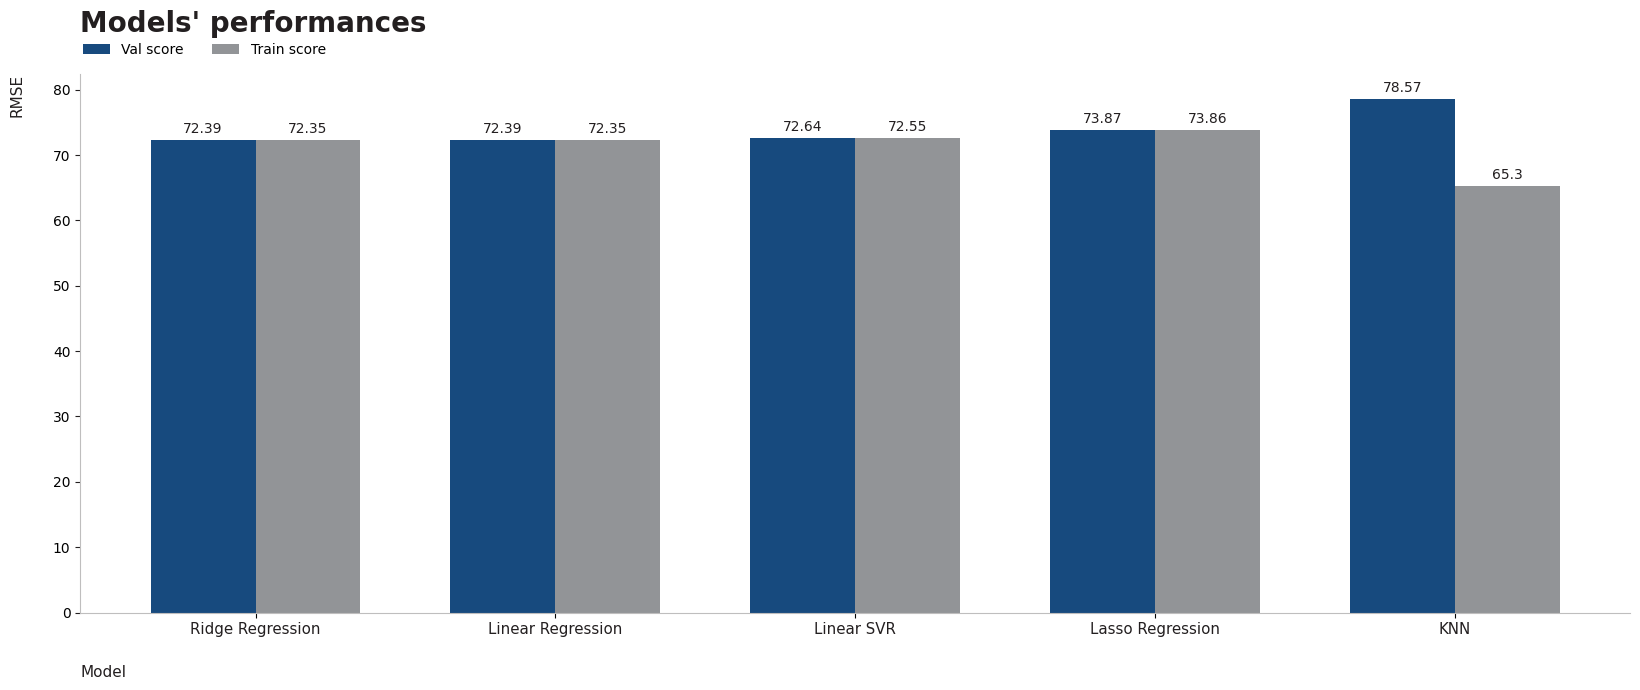

In [168]:
# K-fold cross validation for linear models.
eval_df = regression_kfold_cv(models=linear_models, 
                              X_train=X_train_sample_linear, 
                              y_train=y_train_sample, 
                              n_folds=5)
plot_regression_kfold_cv(eval_df, title_size=20)
eval_df

Decision Tree results: 
--------------------------------------------------
Training score: 41.5860310674229
Average validation score: 96.25266781580902
Standard deviation: 0.18886625370951396
Training time: 0.3202 seconds

Random Forest results: 
--------------------------------------------------
Training score: 46.53996932491621
Average validation score: 78.47588827133467
Standard deviation: 0.3429072945201193
Training time: 19.667 seconds

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 18
[LightGBM] [Info] Start training from score 543.186114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002514 seconds.
You can set `force_row_wise=true` to remov

,model,avg_val_score,train_score
0,LightGBM,71.505106,70.591120
1,Random Forest,78.475888,46.539969
2,Decision Tree,96.252668,41.586031


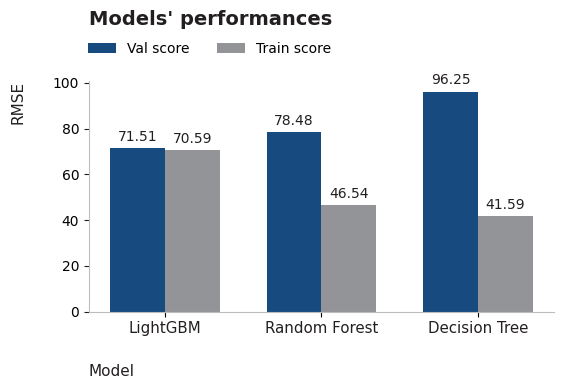

In [212]:
# K-fold cross validation for tree-based models.
eval_df = regression_kfold_cv(models=tree_models, 
                              X_train=X_train_sample_tree, 
                              y_train=y_train_sample, 
                              n_folds=5)
plot_regression_kfold_cv(eval_df, bar_width=0.35, figsize=(6, 3), title_size=14, legend_x=0.26, legend_y=1.22, title_pad=40)
eval_df

- Machine learning é sim uma solução adequada para o problema, o nosso baseline Dummy Regressor foi batido.
- Dado que o melhor modelo foi o LightGBM e que estamos focando em poder preditivo, irei prosseguir com ele para a seleção de features e tunagem de hiperparâmetros.


#### 6. Seleção de features
- A etapa de feature selection é crucial para melhorar a habilidade de generalização do modelo e torná-lo menos complexo, diminuindo o custo computacional. Dado que temos milhões de linhas em nossos dados, simplificar o modelo sem perder performance é de grande proveito.
- O método escolhido será o ProbeFeatureSelection. Basicamente, é introduzida uma variável aleatória nos dados, seguindo uma distribuição especificada (normal, binominal, uniforme, etc.). Então, é acessada a feature importance de todas variáveis. Aquelas que possuem feature importance menor que a da Probe Feature serão removidas. 
- Escolhi esse método por conta da sua simplicidade, não aplicando testes estatísticos ou realizando suposições sobre os dados, além de seu custo reduzido, dada a simples remoção por corte de threshold (feature importance da Probe Feature).

In [6]:
# Instantiate the probe feature selector.
probe_selector = ProbeFeatureSelection(
    estimator=LGBMRegressor(),
    variables=None,
    scoring='neg_root_mean_squared_error',
    n_probes=1,
    distribution='normal',
    cv=3,
    random_state=42,
    confirm_variables=False
)

# Fit it to the training data.
X_train_sel_tree = probe_selector.fit_transform(X_train_prepared_tree, y_train)
X_test_sel_tree = probe_selector.transform(X_test_prepared_tree)

# Assess some results.
print()
print(f'Variáveis removidas: {probe_selector.features_to_drop_}')
print()
print(f'Variáveis remanescentes: {probe_selector.get_feature_names_out()}')
print()
print(f'Feature importances: ')
print(probe_selector.feature_importances_.sort_values(ascending=False))
print()
print(f'Dimensões do conjunto de treinamento final: {X_train_sel_tree.shape}')
print()
print(f'Dimensões do conjunto de teste final: {X_test_sel_tree.shape}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 1250560, number of used features: 19
[LightGBM] [Info] Start training from score 543.468156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 1250560, number of used features: 19
[LightGBM] [Info] Start training from score 543.488103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

- Como esperado, dado o desbalanceamento, variáveis como acesso_internet_em_casa e possui_celular_em_casa foram removidas. A grande surpresa está na remoção de renda_familiar_mensal e numero_pessoas_em_casa, que tiveram feature importance abaixo da Probe Feature, variável aleatória de distribuição normal.

In [7]:
# Visualize the data containing the remaining features.
X_train_sel_tree.head()

,acesso_tecnologico,renda_por_pessoa,renda_por_acesso_tecnologico,acesso_tecnologico_por_pessoa,sexo_M,lingua_Inglês,faixa_etaria,status_conclusao_ensino_medio,escolaridade_pai,escolaridade_mae,escola,regiao,estado_civil,possui_computador_em_casa
0,4,1515.000000,1515.0,1.00,0,1,0,1,4,4,547.736414,564.016491,545.237211,556.205887
1,3,606.000000,404.0,1.50,1,1,1,3,3,0,547.736414,529.203073,545.237211,556.205887
2,3,378.750000,505.0,0.75,0,1,0,1,4,5,547.736414,541.985323,530.033655,504.563823
3,5,4848.000000,4848.0,1.00,0,1,1,3,4,6,547.736414,556.104425,545.237211,606.182385
4,2,242.399994,606.0,0.40,0,1,1,3,5,4,547.736414,513.610479,545.237211,504.563823


#### 7. Tunagem de hiperparâmetros
- Irei tunar os hiperparâmetros do LightGBM utilizando a otimização bayesiana através da biblioteca optuna.
- A otimização bayesiana realiza buscas inteligentes no espaço de hiperparâmetros do modelo, balanceando o trade-off exploration-exploitation.
- O grid search é ineficiente pois realiza uma busca exaustiva, testando todas as combinações de parâmetros possíveis e não considerando efeitos da interação entre parâmetros. Isso seria ruim no nosso caso, pois o conjunto de dados de treinamento é extenso e parâmetros como o número de árvores e a taxa de aprendizado estão relacionados a outros.
- Em cada iteração, treinaremos o modelo com os parâmetros no conjunto de treinamento e avaliaremos no conjunto de validação, para evitar o overfit decorrente do ajuste excessivo de hiperparâmetros no conjunto de treinamento.
- A tunagem de hiperparâmetros representa um refinamento. O que melhora consideravelmente a performance do modelo é a etapa de feature engineering.
- A referência adotada para escolha dos hiperparâmetros pode ser encontrada no link a seguir. Normalmente, um maior número de árvores e iterações seria definido. Entretanto, dado o volume de dados, esses parâmetros serão reduzidos.
- https://www.linkedin.com/posts/pedro-almeida-ds_voc%C3%AA-fica-perdido-sobre-quais-combina%C3%A7%C3%B5es-activity-7168232226965385216-bvtw?utm_source=share&utm_medium=member_desktop

In [8]:
# Preprocess the validation set, apply the same probe feature selection and reset y_val indexes.
X_val_prepared_tree = tree_preprocessor.transform(X_val)
X_val_sel_tree = probe_selector.transform(X_val_prepared_tree)
y_val = y_val.reset_index(drop=True)

In [239]:
def objective(trial):
    # Define the hyperparameter search space.
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': 1000,
        'verbosity': -1,
        'bagging_freq': 1,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    # Train the LightGBM model with the sampled hyperparameters.
    model = LGBMRegressor(**params)
    model.fit(X_train_sel_tree, y_train)

    # Make predictions on the validation set.
    y_pred = model.predict(X_val_sel_tree)

    # Calculate the root mean squared error.
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Optimize the objective function
study.optimize(objective, n_trials=30)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-03-19 22:23:08,365] A new study created in memory with name: no-name-23fd11b1-621d-4d5b-8a08-e3f2a4ad2aa1
[I 2024-03-19 22:24:28,337] Trial 0 finished with value: 71.13330048040672 and parameters: {'learning_rate': 0.016758074138010354, 'num_leaves': 798, 'subsample': 0.6931061007317112, 'colsample_bytree': 0.2147405699267489, 'min_data_in_leaf': 36}. Best is trial 0 with value: 71.13330048040672.
[I 2024-03-19 22:27:39,210] Trial 1 finished with value: 72.88376458717681 and parameters: {'learning_rate': 0.001229211474172469, 'num_leaves': 825, 'subsample': 0.586500022585293, 'colsample_bytree': 0.9740281593915237, 'min_data_in_leaf': 17}. Best is trial 0 with value: 71.13330048040672.
[I 2024-03-19 22:29:42,017] Trial 2 finished with value: 73.1093778633853 and parameters: {'learning_rate': 0.0012565153692073755, 'num_leaves': 330, 'subsample': 0.876378475172906, 'colsample_bytree': 0.7059912953879092, 'min_data_in_leaf': 35}. Best is trial 0 with value: 71.13330048040672.
[I 

Best Hyperparameters: {'learning_rate': 0.01465754808674557, 'num_leaves': 241, 'subsample': 0.28281790477686375, 'colsample_bytree': 0.6687209990993495, 'min_data_in_leaf': 46}


- É possível perceber que, em relação à validação cruzada, o RMSE reduziu de 71.50 para 70.96. Apenas um refinamento.

#### 8. Avaliação do modelo final
- Avaliarei a performance do modelo final tunado no conjunto de testes, dados nunca vistos antes pelo modelo, simulando o ambiente de produção.
- Para avaliá-lo, serão analisadas algumas métricas, como o RMSE, MSE, MAE, MAPE e R2.
- Após avaliar o modelo, eu irei interpretar os seus resultados. 

- Treinando o modelo final em todo o conjunto (treino + validação), com os melhores parâmetros encontrados na busca bayesiana e efetuando as predições.

In [9]:
# Obtain best model with best parameters found in bayesian optimization.
best_params = {
               'objective': 'regression',
               'metric': 'rmse',
               'n_estimators': 1000,
               'verbosity': -1,
               'bagging_freq': 1,
               'learning_rate': 0.01465754808674557, 
               'num_leaves': 241, 
               'subsample': 0.28281790477686375, 
               'colsample_bytree': 0.6687209990993495, 
               'min_data_in_leaf': 46
               }

lgb_reg = LGBMRegressor(**best_params)

# Obtain training + validation predictor and target sets.
X_train_prepared = pd.concat([X_train_sel_tree, X_val_sel_tree])
y_train = pd.concat([y_train, y_val])

# Fit the model to the training data and predict.
lgb_reg.fit(X_train_prepared, y_train)
y_pred = lgb_reg.predict(X_test_sel_tree)

- Observando alguns valores reais e preditos para a nota geral.

In [279]:
actual_pred_df = compare_actual_predicted(y_test, y_pred)
actual_pred_df.sample(15)

,Actual,Predicted,Residual
124753,491.940002,481.06,10.88
66833,538.099976,508.81,29.29
143779,549.940002,558.20,8.26
49459,639.059998,588.22,50.84
155004,689.799988,621.53,68.27
225545,732.760010,502.66,230.10
86986,565.919983,496.06,69.86
103586,522.500000,501.43,21.07
29983,630.479980,571.41,59.07
15645,504.040009,488.13,15.91


- É possível perceber que o modelo tende a errar mais em casos mais extremos, como notas abaixo da média (valores como 300) e notas acima da média (valores como 700). No geral, considerando as variáveis que tínhamos, o resultado parece satisfatório.

- Métricas de regressão.

Mean Absolute Error (MAE): 55.6998
Mean Absolute Percentage Error (MAPE): 10.8232
Mean Squared Error (MSE): 5057.7289
Root Mean Squared Error (RMSE): 71.1177
R-Squared (R2): 0.3449


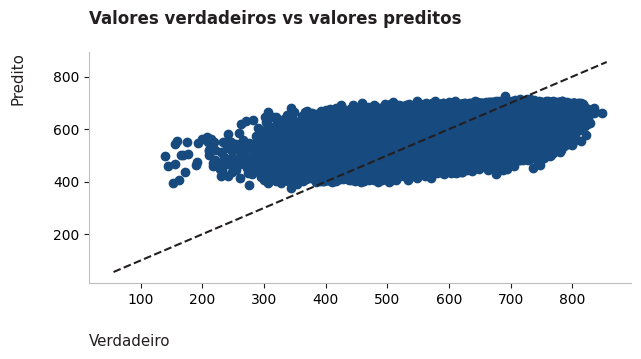

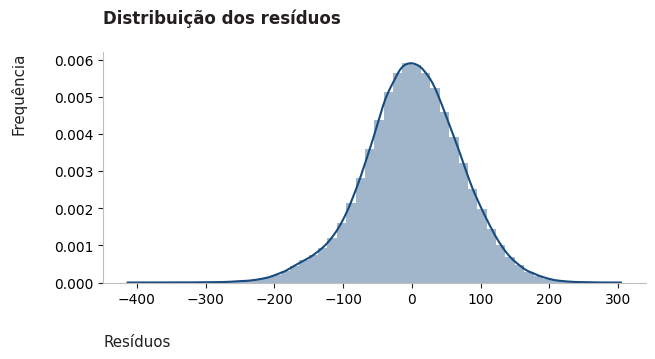

In [290]:
df_results = evaluate_regressor(y_test, y_pred, y_train, 'LightGBM')

In [276]:
df_results

,Model,MAE,MAPE,RMSE,R2
Results,LightGBM,55.6998,10.8232,71.1177,0.3449


In [291]:
print(f'Valor mínimo predito = {round(y_pred.min(), 2):.2f}  |  Valor mínimo real = {round(y_test.min(), 2):.2f}')
print(f'Valor máximo predito = {round(y_pred.max(), 2):.2f}  |  Valor máximo real = {round(y_test.max(), 2):.2f}')

Valor mínimo predito = 374.78  |  Valor mínimo real = 140.18
Valor máximo predito = 725.23  |  Valor máximo real = 848.32


- O modelo final apresenta uma performance satisfatória:
    - MAE (Erro Absoluto Médio): O MAE de 55.7 indica que, em média, as previsões do modelo estão desviadas por 55.7 pontos em relação às notas reais dos alunos no enem.
    - MAPE (Erro Percentual Absoluto Médio): O MAPE de 10.8% sugere que, em média, as previsões do modelo têm um desvio percentual absoluto de 10.8% em relação às notas reais dos alunos no enem.
    - RMSE (Raiz do Erro Quadrático Médio): O RMSE de 71.11 indica que, em média, as previsões do modelo têm um desvio de 71.11 pontos em relação às notas reais dos alunos no ENEM, considerando a penalização dos erros quadráticos.
    - R2: O R2 de 0.345 indica que aproximadamente 34.5% da variabilidade nas notas dos alunos no enem é explicada pelo modelo de regressão. Isso sugere uma explicação limitada da variação nas notas, indicando que o modelo pode não capturar totalmente os padrões presentes nos dados.
    - É possível perceber que o modelo tem maior dificuldade em prever outliers, como notas muito acima da média e notas muito abaixo dela. Por exemplo, o valor predito mínimo é de 374.78, enquanto o valor real mínimo é de 140. Além disso, o valor predito máximo é de 725.23, enquanto o valor real máximo é de 848. Isso ocorre porque esses valores são raros, havendo uma enorme concentração em torno da média, como foi possível observar na eda. A distribuição das notas gerais é quase normal, exceto por uma ligeira cauda à esquerda contendo essas notas baixíssimas.
    - A observação acima é reforçada analisando-se a distribuição dos resíduos. Os resíduos possuem média zero e estão quase normalmente distribuídos, exceto por uma cauda maior à esquerda. Essa cauda indica que o modelo tende a prever valores maiores para notas reais menores. Essa é uma das suposições da regressão linear, e não está sendo fielmente atendida. 
        - Para contornar isso e melhorar o modelo, seria interessante realizar uma feature engineering focada nessas observações com valores maiores ou menores de nota. Além disso, incluir variáveis com maior poder preditivo também seria de ótimo proveito.
        - Não é interessante remover esses outliers, afinal, na realidade haverá alunos que não se capacitaram e tirarão notas baixíssimas e alunos que estudaram muito, gabaritando as provas e obtendo um desempenho altíssimo.
- Considerando uma nota média de todos os alunos no ENEM de 543, essas métricas indicam que o modelo tem bom poder preditivo, mas há espaço para melhorias, pois os erros médios e percentuais ainda são significativos.

- Vamos comparar o RMSE do modelo nas amostras de treino, teste e validação, a fim de se certificar que o modelo não está com overfit.
- Além disso, é importante aplicar a validação cruzada k-fold mais uma vez, a fim de verificar a performance do modelo final em diferentes conjuntos de dados nunca antes vistos. Isso mitiga efeitos da variabilidade dos dados e nos fornece uma visão concreta da capacidade de generalização do estimador.

In [294]:
# Predict on train, test and validation sets.
y_pred_train = lgb_reg.predict(X_train_sel_tree)
y_pred_val = lgb_reg.predict(X_val_sel_tree)
y_pred_test = y_pred

# K-fold cross validation
cv_scores = cross_val_score(lgb_reg,
                            X_train_sel_tree,
                            y_train,
                            scoring='neg_mean_squared_error',
                            cv=5)
rmse_cv = round(np.sqrt(-1 * np.mean(cv_scores)), 2)

# Obtain RMSE on each of these sets.
rmse_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)), 2)
rmse_test = round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2)
rmse_val = round(np.sqrt(mean_squared_error(y_val, y_pred_val)), 2)

# Output a dataframe for better visualization.
train_test_val_rmse = pd.DataFrame({'RMSE': [rmse_train, rmse_val, rmse_test, rmse_cv]}, index=['Train', 'Test', 'Val', 'Cross Val'])
train_test_val_rmse

,RMSE
Train,70.83
Test,70.60
Val,71.12
Cross Val,71.22


- Os scores nos conjuntos de treino, teste e validação e na validação cruzada k-fold são similares. Portanto, o modelo não está com overfit e generaliza de forma satisfatória para instâncias nunca antes vistas.

#### 9. Interpretação dos resultados
- Para interpretar os resultados do LightGBM, vou analisar os valores SHAP.
- SHAP é uma biblioteca que permite a interpretação dos resultados de algoritmos de machine learning.
- Com ela, podemos entender o impacto de cada característica em uma previsão individual do modelo.
- Basicamente, o valor SHAP de uma característica (o quanto ela impacta em uma previsão individual) é a soma ponderada das contribuições marginais considerando todas as possíveis combinações de características.
- Uma combinação de características é um grupo delas, e seu valor é a previsão individual do modelo utilizando apenas essas características.
- A contribuição marginal de uma característica é a diferença entre o valor previsto para uma combinação de características com ela e sem ela.
- Somamos as contribuições marginais para todas as possíveis combinações com e sem uma característica.
- Os pesos são baseados na probabilidade de a característica que estamos calculando o valor SHAP estar nessa combinação.
- Também podemos agregar as contribuições individuais, obtendo uma noção das feature importances. Vários plots serão explorados abaixo.

$$
\phi_i(v) = \sum_{S \subseteq F \setminus \{i\}} \frac{|S|!(|F| - |S| - 1)!}{|F|!} \left[ f(S \cup \{i\}) - f(S) \right]
$$

Onde:
- $ \phi_i(v) $ representa o SHAP value da feature $ i $ para a predição $ v $.
- $ F $ representa o conjunto de todas as features.
- $ S $ representa um subset de features excluindo a feature $ i $.
- $ f $ é a função de predição do modelo. 

In [11]:
# Initialize the SHAP explainer with the final model.
explainer = shap.Explainer(lgb_reg)

# Compute shap values.
shap_values = explainer(X_test_sel_tree)

In [13]:
# Assess the shape.
np.shape(shap_values.values)

(234480, 14)

In [14]:
# Assess some true labels.
y_test.head(10)

0    647.719971
1    563.440002
2    542.799988
3    568.659973
4    622.140015
5    387.539978
6    563.400024
7    549.520020
8    301.940002
9    506.520020
Name: nota_geral, dtype: float32

- Temos 14 variáveis. Para cada uma temos um valor shap correspondente a cada observação.
- Nos gráficos a seguir, E(f(X)) representa a previsão média de nota geral e f(x) a nota geral predita para aquela observação. Os valores de shap positivos aumentam a nota geral e os valores negativos a diminuem. 
- Através do gráfico waterfall, iremos visualizar a contribuição de cada feature na predição da nota geral de um candidato.

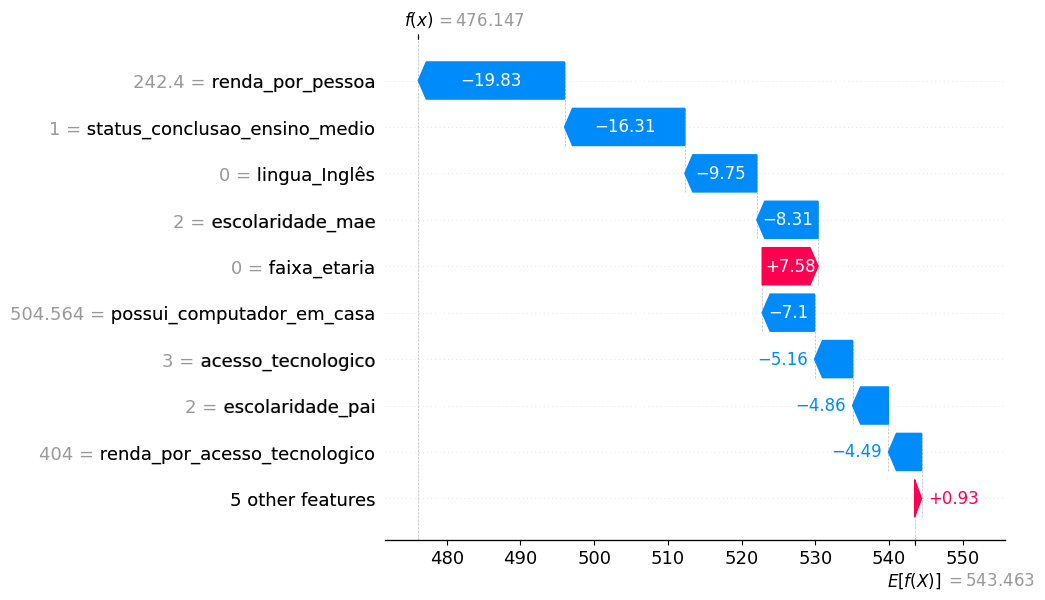

In [52]:
shap.plots.waterfall(shap_values[50])

- Como podemos ver, para este candidato, que teve nota predita 476, a baixa renda por pessoa (em torno de 242 reais) diminui a nota predita em quase 20 pontos. Da mesma forma, o fato de ter escolhido Espanhol como língua e a baixa escolaridade da mãe (ensino fundamental incompleto) impactam negativamente a nota. Além de outros fatores, como escolaridade do pai, acesso tecnológico e faixa etária.

- Agora, através do gráfico bar, iremos observer quais features são mais importantes. Neste gráfico, temos o shap absoluto médio para cada feature, indicando quais features contribuem mais (de forma positiva ou negativa) nas predições do modelo.

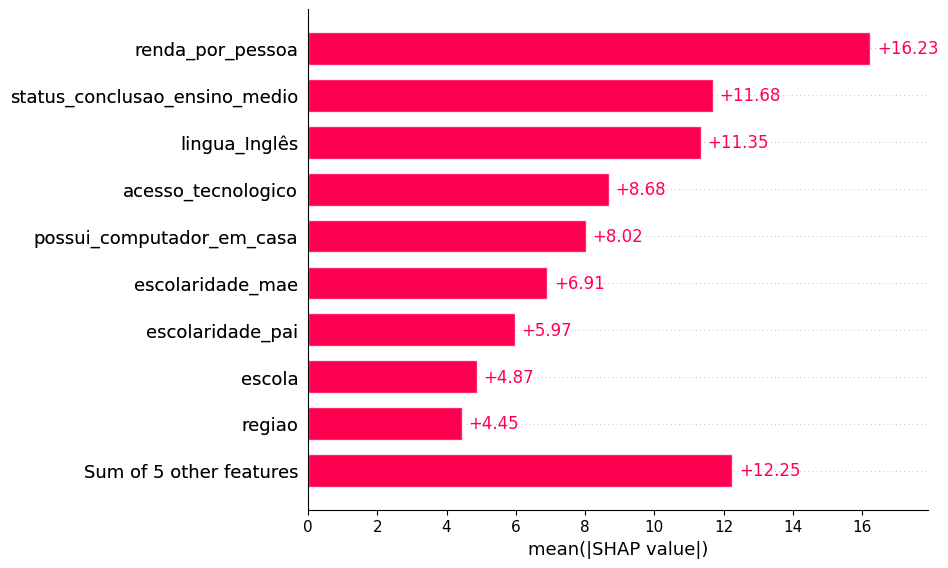

In [53]:
shap.plots.bar(shap_values)

- A renda por pessoa se destaca como variável mais importante, tendo o maior shap value absoluto médio. Isso faz total sentido, uma vez que, quanto menor a renda, menor tende a ser a nota do candidato, como observado na eda.

- Agora, através do gráfico beeswarm, podemos observar o relacionamento entre as features e a predição do modelo.

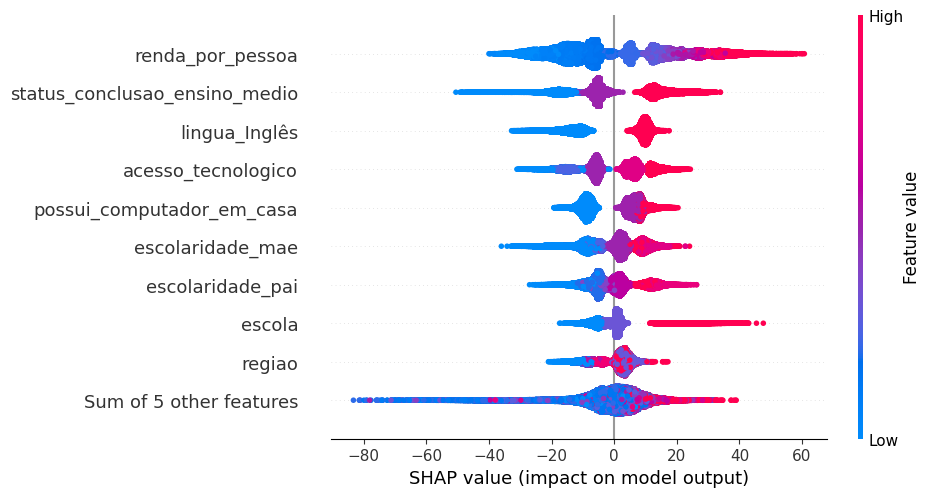

In [54]:
shap.plots.beeswarm(shap_values)

- Claramente, maiores valores de renda_por_pessoa (em maior magnitude) impactam de forma positiva a predição do modelo, isto é, aumentam a nota, enquanto menores valores a diminuem. 
- Especialmente em escola, há uma clara distinção. Maiores valores, que correspondem a escola particular, impactam de forma positiva o modelo, aumentando a nota. Já escola pública ou a categoria sem resposta impactam de forma negativa. Nessa feature, há uma separação clara. A mesma separação é perceptível em variáveis como lingua_inglês e status_conclusao_ensino_medio. Surpreendente como a escolha de inglês como língua estrangeira é um padrão nos candidatos com maiores notas. A importância dessa língua estrangeira está presente até neste caso. 
- Em geral, a mesma tendência é percebida nas outras features.

#### 10. Conclusão

- Neste notebook, foi desenvolvido um modelo preditivo (LightGBM) para predição da nota geral do candidato no enem. 
- Foram consideradas diversas variáveis na construção do modelo. Os insights obtidos na etapa de análise exploratória de dados serviram de guia para a tarefa de pré-processamento de dados, necessária para a aplicação de algoritmos de machine learning.
- Após o pré-processamento de dados, avaliamos através da validação cruzada k-fold modelos potenciais, a fim de selecionar um deles para a seleção de features e tunagem de hiperparâmetros e avaliação final no conjunto de testes, simulando o ambiente de produção. O modelo selecionado foi o LightGBM, pois apresentou o menor erro de validação.
- Realizei a feature selection introduzindo uma ProbeFeature, que é uma variável aleatória com distribuição normal. Então, aquelas variáveis com feature importance menor que o da Probe Feature foram removidas, restando 14 variáveis, simplificando o modelo e diminuindo o custo, dado que temos milhões de linhas.
- O resultado obtido foi satisfatório, porém há espaço para melhorias:
    - Com um MAE de aproximadamente 55.7, as previsões do modelo são desviadas, em média, de 55.7 pontos em relação às notas reais dos candidatos no enem.
    - Com um R2 de 0.345, aproximadamente 34.5% da variância do target é explicada pelo modelo/variáveis independentes. 
    - Foi observado que o modelo tende a errar mais para valores extremos, como notas baixíssimas próximas a 100 e notas altíssimas na casa dos 800 pontos. Isso ocorre porque a grande massa de notas tende a se concentrar em torno do valor médio, na casa do 500-600 pontos. Talvez uma feature engineering focada nessas notas maiores e menores e/ou a introdução de variáveis com potencial preditivo maior melhorasse esse aspecto. Isso será testado no futuro.
    - Os erros nas amostras de treino, teste e validação são similares, indicando que o modelo não está com overfit e generaliza de forma satisfatória para instâncias nunca antes vistas.
    - Os resultados foram interpretados através da biblioteca SHAP, fornecendo uma visão do impacto de cada variável nas predições individuais e a sua importância agregada através dos valores shapley.
- Os resultados foram interpretados através da biblioteca SHAP, fornecendo uma visão do impacto de cada variável nas predições individuais e a sua importância agregada através dos SHAP values. Por exemplo, através do gráfico beeswarm, vemos que:
    - Claramente, maiores valores de renda_por_pessoa (em maior magnitude) impactam de forma positiva a predição do modelo, isto é, aumentam a nota, enquanto menores valores a diminuem. 
    - Especialmente em escola, há uma clara distinção. Maiores valores, que correspondem a escola particular, impactam de forma positiva o modelo, aumentando a nota. Já escola pública ou a categoria sem resposta impactam de forma negativa. Nessa feature, há uma separação clara. A mesma separação é perceptível em variáveis como lingua_inglês e status_conclusao_ensino_medio. Surpreendente como a escolha de inglês como língua estrangeira é um padrão nos candidatos com maiores notas. A importância dessa língua estrangeira está presente até neste caso. 
    - Em geral, a mesma tendência é percebida nas outras features.
    - Note a importância da etapa de feature engineering. A variável mais importante foi criada por mim, aplicando uma simples razão entre renda_familiar_mensal e numero_pessoas_em_casa.
- Para os próximos passos, estão o deploy do modelo em produção.